In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [2]:
#Data processing
datR = pd.read_csv("../data/winequality/winequality-red.csv",sep=";")
datR['col']='R'
datW = pd.read_csv("../data/winequality/winequality-white.csv",sep=";")
datW['col']='W'
dat = pd.concat([
    datR,datW
])

target = 'quality'
orig_onehot_features = ['col']
orig_numeric_features = [i for i in dat.columns if i not in [target]+orig_onehot_features]

Xonehot = OneHotEncoder(drop='first').fit_transform(dat[orig_onehot_features])
dat['colW']=Xonehot.toarray()

processed_features = orig_numeric_features+['colW']

In [10]:
#Linear model
X = dat[processed_features].copy()
Y = dat[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2,random_state=42,shuffle=True)

model = Pipeline(steps = [
    ('scaler',MinMaxScaler()),
    #('learner',Lasso(fit_intercept=True,alpha=1e-2))
    #('learner',LinearRegression(fit_intercept=True))
    ('learner',Ridge(fit_intercept=True,alpha=1e1))
])

model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('learner', Ridge(alpha=10.0))])

0.26504228144732445 0.2914448183959285


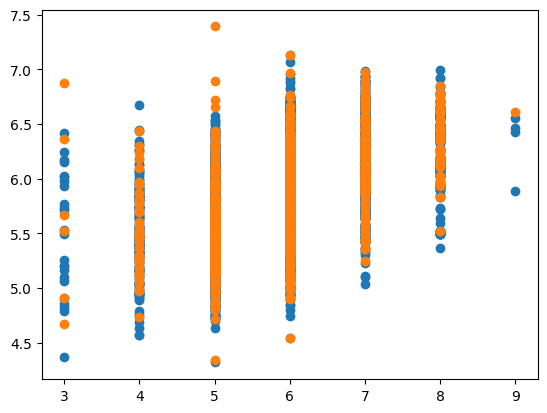

In [11]:
y_fit, y_pred = model.predict(X_train),model.predict(X_test)
plt.scatter(y_train,y_fit)
plt.scatter(y_test,y_pred)
r2 = 1-sum((y_test-y_pred)**2)/sum((y_test-y_test.mean())**2)
r2_train = 1-sum((y_train-y_fit)**2)/sum((y_train-y_train.mean())**2)
print(r2,r2_train)

In [12]:
xor = pd.DataFrame({
    'x1':[0,0,1,1],
    'x2':[0,1,0,1],
    'y':[0,1,1,0]
})
xor['(x1-x2)**2']=(xor['x1'] - xor['x2'])**2
xor

,x1,x2,y,(x1-x2)**2
0,0,0,0,0
1,0,1,1,1
2,1,0,1,1
3,1,1,0,0


In [13]:
#Scaling data for kernel transform
#(x1-x2)**2
scaler = MinMaxScaler().fit(X_train)
X_train_1 = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns,index=X_train.index)
X_test_1 = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

In [14]:

def make_kernel_transform(X_train_1):
    X_train_2 = pd.DataFrame()

    for col1 in X_train_1.columns:
        for col2 in X_train_1.columns:
            cols = [col1,col2]
            cols.sort()
            colname = "-".join(cols)
            if (col1!=col2)&(colname not in X_train_2.columns):
                X_train_2[colname] = (X_train_1[col1]-X_train_1[col2])**2

    return X_train_2

X_train_2 = make_kernel_transform(X_train_1)
X_test_2 = make_kernel_transform(X_test_1)
                
X_train_3 = pd.concat([X_train_2,X_train_1],axis=1)
X_test_3 = pd.concat([X_test_2,X_test_1],axis=1)

In [28]:

model2 = Pipeline(steps = [
    ('scaler',MinMaxScaler()),
    #('learner',Lasso(fit_intercept=True,alpha=1e-2))
    #('learner',LinearRegression(fit_intercept=True))
    ('learner',Ridge(fit_intercept=True,alpha=12))
])

model2.fit(X_train_2,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('learner', Ridge(alpha=12))])

0.27063017922966104 0.326210999586779


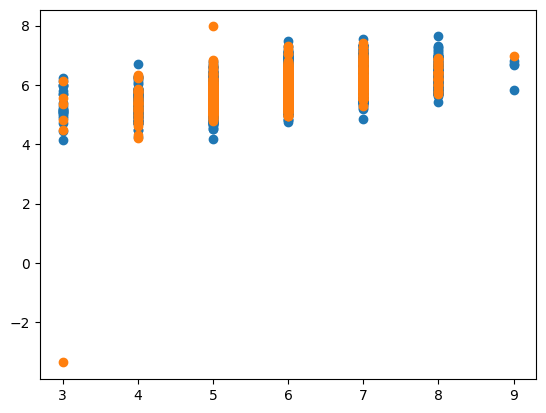

In [29]:
y_fit, y_pred = model2.predict(X_train_2),model2.predict(X_test_2)
plt.scatter(y_train,y_fit)
plt.scatter(y_test,y_pred)
r2 = 1-sum((y_test-y_pred)**2)/sum((y_test-y_test.mean())**2)
r2_train = 1-sum((y_train-y_fit)**2)/sum((y_train-y_train.mean())**2)
print(r2,r2_train)